(continuous_hgf)=
# The continuous Hirarchical Gaussian Filter

In [27]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ghgf import load_data
from ghgf.model import HGF
import seaborn as sns
from math import log

sns.set_context("talk")

In this notebook, we demonstrate how to use the standard 2-levels and 3-level Hierarchical Gaussian Filters (HGF) for continuous inputs. This class of models differs from the previous example asw the input node can now accepts continuous input data. Fitting continuous data allows to use the HGF with any time series, which makes it especially suitable for the modelling of physiological signals (see also the case study on modelling heart rate variability using the Hierarchical Gaussian Filter).  The continuous version of the Hierarchical Gaussian Filter can take the following structures:

```{figure} ../images/continuous.svg

---
name: continuous-hgf
---
The 2-levels and 3-level Hierarchical Gaussian Filter for continuous inputs.
```

Here, we will use the continuous HGF to predict the evolution of currency exchage across time (this time series is a classical example used in the Matlab toolbox).

## Imports

In this example, we will use the exchange rate of the US Dollar to the Swiss Franc during much of 2010 and 2011 as a time series that the continuous HGF is going to predict.

In [2]:
timeserie = load_data("continuous")

## Fitting the continuous HGF with fixed parameters
### The 2-levels continuous Hierarchical Gaussian Filter
#### Create the model

```{note}
The response function used is the Guassian surprise at each time points(:py:func:``ghgf.response.gaussian_surprise`). In other words, at each time point the model try to update its hierarchy to minimize the discrepancy between the expected and real next observation in the continuous domain. See also [this tutorial](#custom_response_function) to see how to create custom response function.
```

In [3]:
two_levels_continuous_hgf = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": -13.0, "2": -12.0},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0})

Creating a continuous Hierarchical Gaussian Filter with 2 levels.


This function create an instance of a HGF model automatically parametrized for a 2-levels continuous structure, so we do not have to worry about creating the nodes structure ourself. This class also embed function to add new observations and plots results that we are going to use below.

#### Add data

In [4]:
# Provide new observations
two_levels_continuous_hgf = two_levels_continuous_hgf.input_data(input_data=timeserie)

Add 614 new continuous observations.


#### Plot trajectories

A Hierarchical Gaussian Filter is acting as a Bayesian filter when presented new observation, and by running the update equation forward, we can observe the trajectories of the nodes parameters that are being updated after each new observation (i.e. the mean $\mu$ and the precision $\pi$). The `plot_trajectories` function automatically extract the relevant parameters given the model structure and will plot their evolution together with the input data.

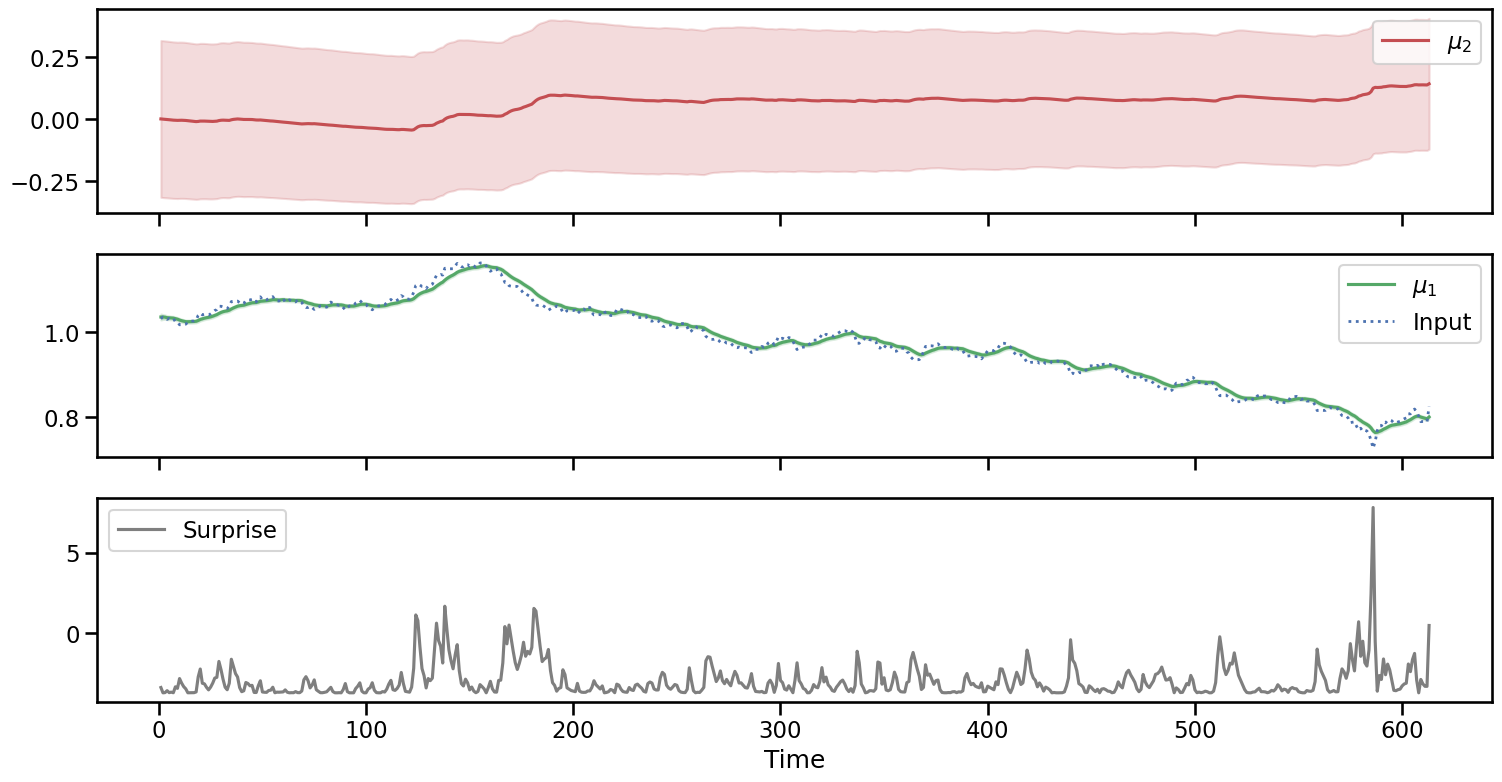

In [5]:
two_levels_continuous_hgf.plot_trajectories()

Looking at the volatility (ie, the second) level, we see that there are two salient events in our time series where volatility shoots up. The first is in April 2010 when the currency markets react to the news that Greece is effectively broke. This leads to a flight into the US dollar (green dots rising very quickly), sending the volatility higher. The second is an accelarating increase in the value of the Swiss Franc in Augutst and September 2011, as the Euro crisis drags on. The point where the Swiss central bank intervened and put a floor under how far the Euro could fall with respect to the Franc is clearly visible in the Franc's valuation against the dollar. This surprising intervention shows up as another spike in volatitlity.

We can see that the surprise will increase when the time series exhibit more unexpected behaviors. The degree to which a given observation is expected will deppends on the expeted value and volatility in the input node, that are influenced by the values of higher order nodes. One way to assess model fit is to look at the total gaussian surprise for each observation. This values can be returned using the `surprise` method:

In [6]:
two_levels_continuous_hgf.surprise()

DeviceArray(-1801.2683, dtype=float32)

```{note}
The surprise of a model under the observation of new data directly depends on the response function that was used. New response functions can be added and provided using different `response_function_parameters` and `response_function` in the py:func:`ghgf.model.HGF.surprise` method. The surprise is then defined as the negative log probability of new observations:

$$surprise = -log(p)$$
```

#### Plot correlation
Node parameters that are highly correlated accross time are likely to indicate that the model did not learn hierarchical structure in the data but instead overfitted on some component. One way to quickly check the parameters nodes correlation is to use the `plot_correlation` function embedded in the HGF class.

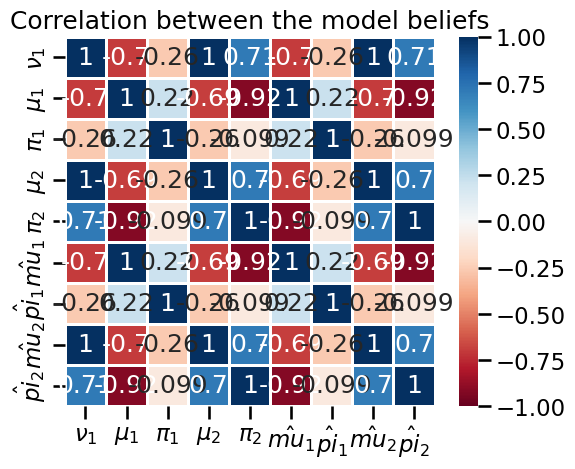

In [7]:
two_levels_continuous_hgf.plot_correlations()

### The 3-levels continuous Hierarchical Gaussian Filter
#### Create the model
Here, we create a new :py:`ghgf.model.HGF` instance, setting the number of levels to `3`. Note that we are extending the size of the dictionaries accordingly.

In [8]:
three_levels_continuous_hgf = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0, "3": 0.0},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": -13.0, "2": -12.0, "3": -12.0},
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 1.0})

Creating a continuous Hierarchical Gaussian Filter with 3 levels.


#### Add data

In [9]:
three_levels_continuous_hgf = three_levels_continuous_hgf.input_data(input_data=timeserie)

Add 614 new continuous observations.


#### Plot trajectories

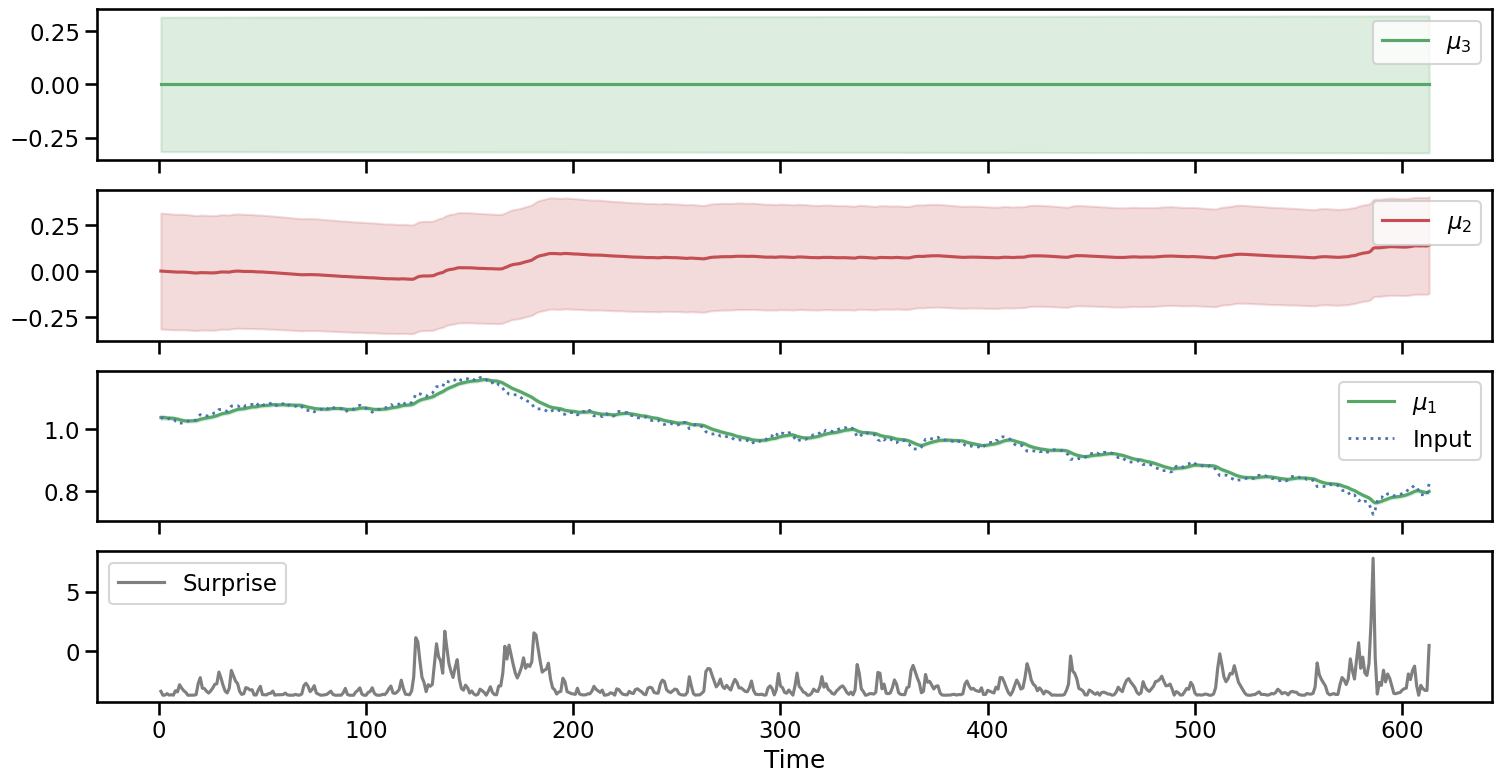

In [10]:
three_levels_continuous_hgf.plot_trajectories()

#### Surprise
Similarly, we can retrieve the overall Gaussian surprise for each new observation using the built-in method:

In [11]:
three_levels_continuous_hgf.surprise()

DeviceArray(-1801.2683, dtype=float32)

Here, the overall amount of surprise returned by the 2-levels and 3-levels HGF are very close. However, those values are also prones to change is the nodes parameters are being optimized beforehand. One important parameters for each node is $\omega$ (`omega`). This is the tonic part of the variance (the part of the variance in each node that is not affected by the parent node). Here we are going to change $\omega$ for both the first and the second level:

In [12]:
# create an alternative model with different omega values
# note that the input time series are been passed in the same call
three_levels_continuous_hgf_bis = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mu={"1": 1.04, "2": 0.0, "3": 0.0},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": -13.0, "2": -6.0, "3": -6.0},
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 1.0}
).input_data(input_data=timeserie)

Creating a continuous Hierarchical Gaussian Filter with 3 levels.
Add 614 new continuous observations.


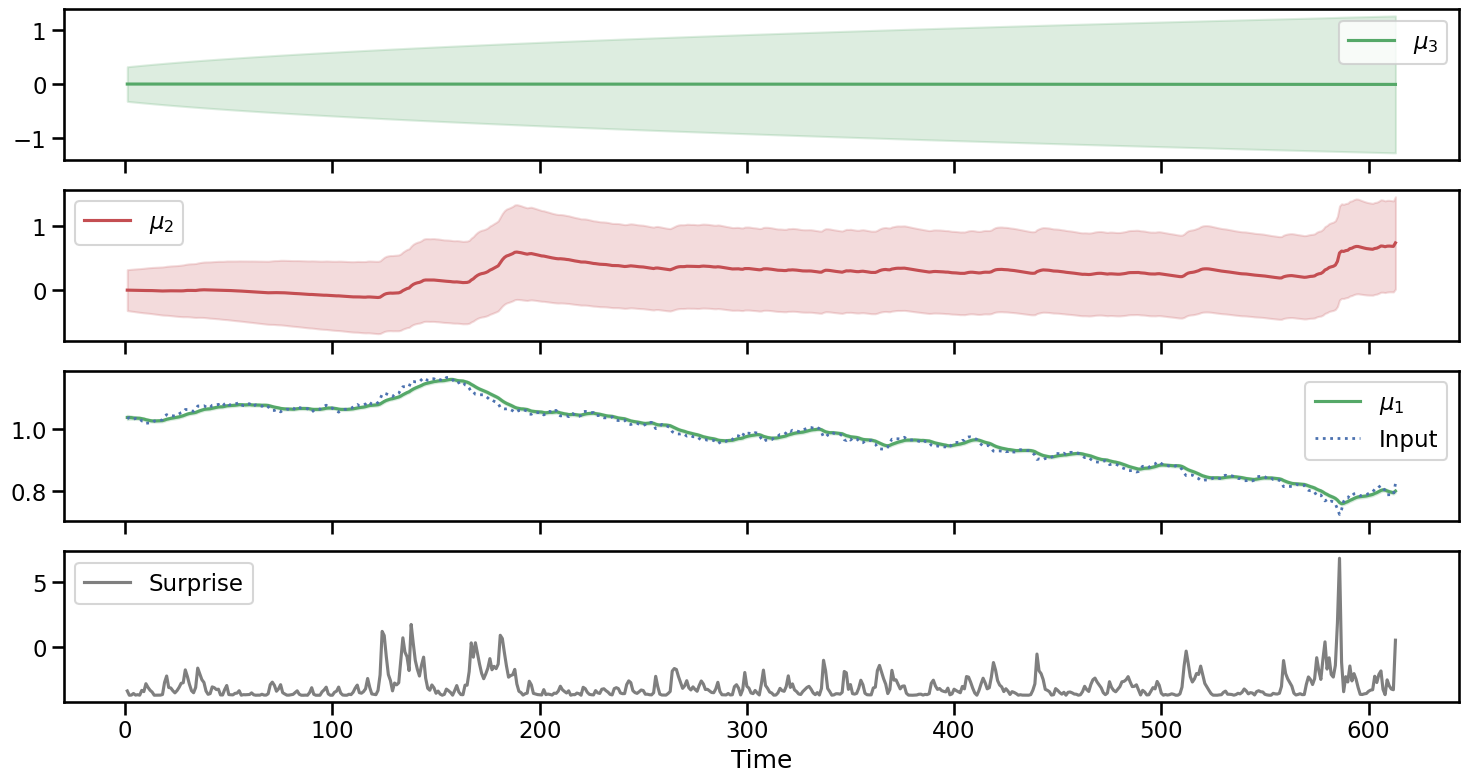

In [13]:
three_levels_continuous_hgf_bis.plot_trajectories()

In [14]:
three_levels_continuous_hgf_bis.surprise()

DeviceArray(-1836.6089, dtype=float32)

Here, we are getting a global surprise of `-1836` with the new model, as compared to a global surprise of `-1801` with the previous parameters set, suggesting that the hierachy was better capturing the hierarchicaly nested volatility of the time series fluctuations.

## Learning parameters with MCMC sampling
In the previous section, we assumed we knew the parameters of the HGF models that were used to filter the input data. This can give us information on how an agent using these values would behave when presented with these inputs. We can also adopt a different perspective and consider that we want to learn these parameters from the data. Here, we are going to set some of the parameters free and use Hamiltonian Monte Carlo methods (NUTS) to sample their probability density.

Because the HGF classes are built on the top of [JAX](https://github.com/google/jax), they are natively differentiable and compatible with optimisation libraries or can be embedded as regular distributions in the context of a Bayesian network. Here, we are using this approach, and we are going to use [PyMC](https://www.pymc.io/welcome.html) to perform this step. PyMC can use any log probability function (here the negative surprise of the model) as a building block for a new distribution by wrapping it in its underlying tensor library [Aesara](https://aesara.readthedocs.io/en/latest/), now forked as [PyTensor](https://pytensor.readthedocs.io/en/latest/). This PyMC-compatible distribution can be found in the :py:`ghgf.distribution` sub-module.

In [24]:
import pymc as pm
import arviz as az
from ghgf.distribution import HGFDistribution
from ghgf.response import gaussian_surprise

### 2-levels model
#### Creating the model

In [25]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    input_data=[timeserie]
)

This log probabilit function can then be embedded in a PyMC model using the same API. Here, we are going to set `omega_1`, `omega_2` and `mu_1` as free parameters. The other parameters are fixed.

```{note}
The data is being passed to the distribution when the instance is created.
```

In [28]:
with pm.Model() as two_level_hgf:
    
    # mus priors
    mu_1 = pm.Normal("mu_1", 0, 10)
    mu_2 = pm.Normal("mu_2", 0, 10)

    # omegas priors
    omega_1 = pm.Normal("omega_1", -6.0, 2)
    normal_dist = pm.Normal.dist(mu=-2.0, sigma=2.0)
    omega_2 = pm.Censored("omega_2", normal_dist, lower=-20.0, upper=2)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=omega_2,
            omega_input=log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=mu_1,
            mu_2=mu_2,
            kappa_1=1.0,
            bias=0.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

```{note}
The $\omega$ parameters are real numbers that are defined from -$\infty$ to +$\infty$. However, as learning rates expressed in log spaces, values higher than 2 are extremely unlikely and could create abberant fits to the data. Therefore, here we are constraining the parameter space using a censored normal distribution (see [pm.Censored](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Censored.html)) that exclude any value higher that 2.0.
```

#### Visualizing the model

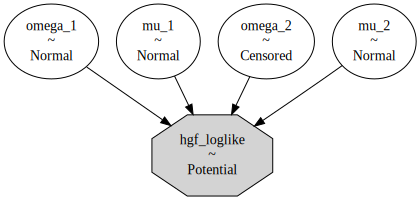

In [29]:
pm.model_to_graphviz(two_level_hgf)

#### Sampling

In [30]:
with two_level_hgf:
    two_level_hgf_idata = pm.sample(chains=4)

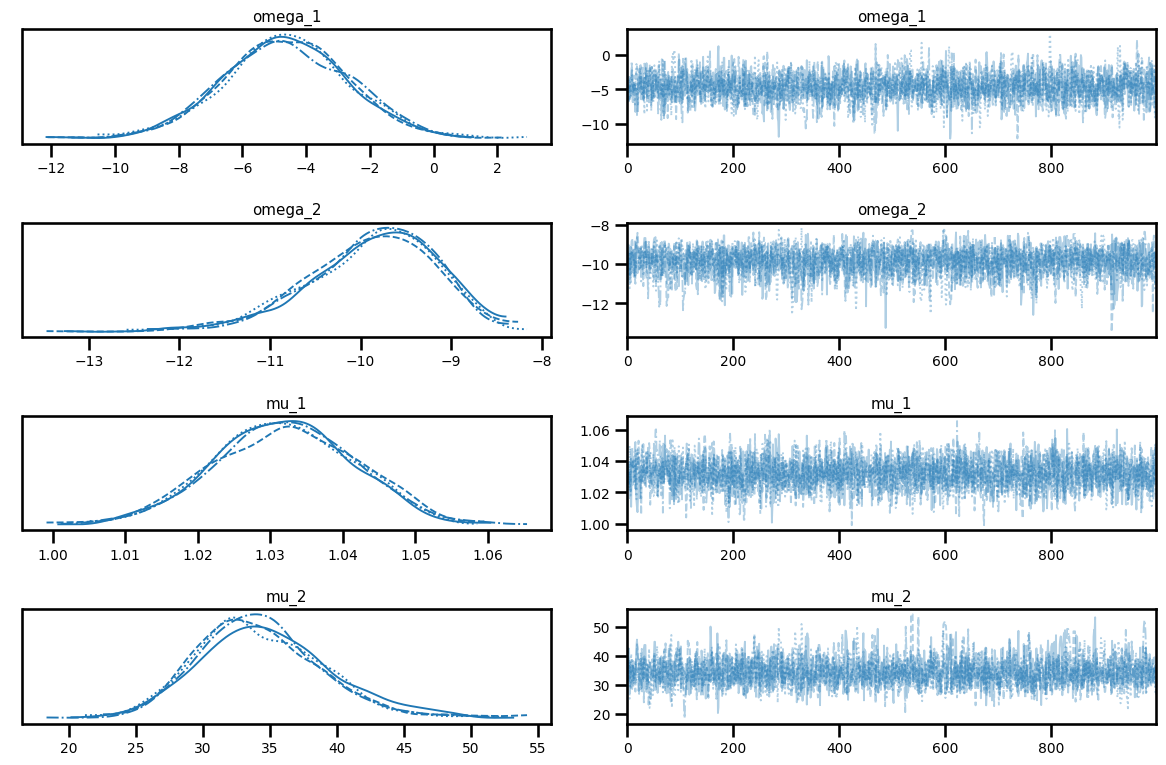

In [31]:
az.plot_trace(two_level_hgf_idata, var_names=["omega_1", "omega_2", "mu_1", "mu_2"]);
plt.tight_layout()

#### Using the learned parameters

In [32]:
omega_1 = az.summary(two_level_hgf_idata)["mean"]["omega_1"]
omega_2 = az.summary(two_level_hgf_idata)["mean"]["omega_2"]
mu_1 = az.summary(two_level_hgf_idata)["mean"]["mu_1"]
mu_2 = az.summary(two_level_hgf_idata)["mean"]["mu_2"]

In [33]:
hgf_mcmc = HGF(
    n_levels=2,
    model_type="continuous",
    initial_mu={"1": mu_1, "2": mu_2},
    initial_pi={"1": 1e4, "2": 1e1},
    omega={"1": omega_1, "2": omega_2},
    rho={"1": 0.0, "2": 0.0},
    kappas={"1": 1.0}).input_data(
        input_data=timeserie
    )

Creating a continuous Hierarchical Gaussian Filter with 2 levels.
Add 614 new continuous observations.


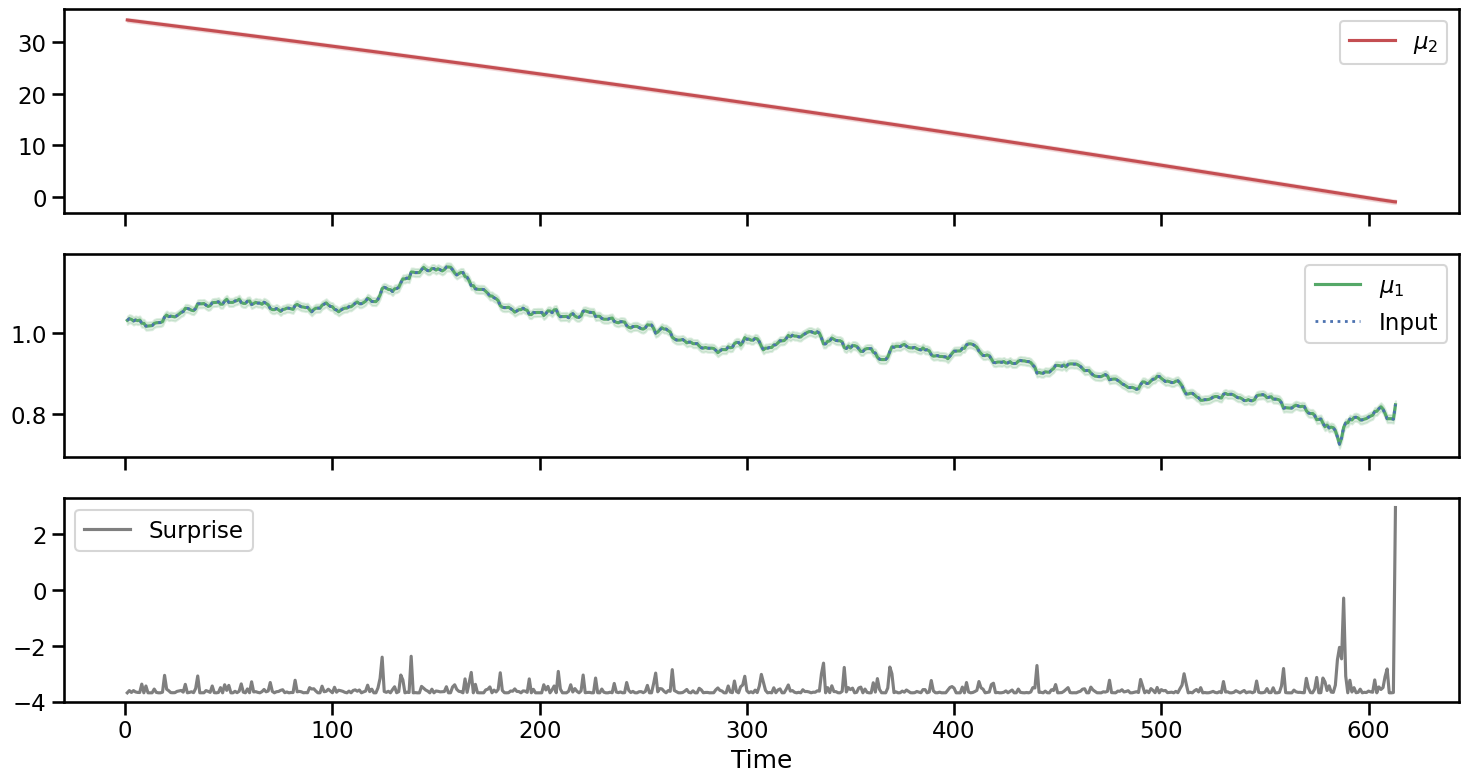

In [34]:
hgf_mcmc.plot_trajectories()

In [35]:
hgf_mcmc.surprise()

DeviceArray(-2181.7927, dtype=float32)

### 3-levels model
#### Creating the model

In [36]:
hgf_logp_op = HGFDistribution(
    n_levels=3,
    input_data=[timeserie]
)

This log probabilit function can then be embedded in a PyMC model using the same API. Here, we are going to set `omega_1`, `omega_2` and `mu_1` as free parameters. The other parameters are fixed.

```{note}
The data is being passed to the distribution when the instance is created.
```

In [38]:
with pm.Model() as three_level_hgf:
    
    # mus priors
    mu_1 = pm.Normal("mu_1", 0, 10)
    mu_2 = pm.Normal("mu_2", 0, 10)
    mu_3 = pm.Normal("mu_3", 0, 10)

    # omegas priors
    omega_1 = pm.Normal("omega_1", -6.0, 2)

    normal_dist = pm.Normal.dist(mu=-2.0, sigma=2.0)
    omega_2 = pm.Censored("omega_2", normal_dist, lower=-20.0, upper=2)

    normal_dist2 = pm.Normal.dist(mu=-2.0, sigma=2.0)
    omega_3 = pm.Censored("omega_3", normal_dist2, lower=-20.0, upper=2)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=omega_2,
            omega_3=omega_3,
            omega_input=log(1e-4),
            rho_1=0.0,
            rho_2=0.0,
            rho_3=0.0,
            pi_1=1e4,
            pi_2=1e1,
            pi_3=1e1,
            mu_1=mu_1,
            mu_2=mu_2,
            mu_3=mu_3,
            kappa_1=1.0,
            kappa_2=1.0,
            bias=0.0,
        ),
    )

```{note}
The $\omega$ parameters are real numbers that are defined from -$\infty$ to +$\infty$. However, as learning rates expressed in log spaces, values higher than 2 are extremely unlikely and could create abberant fits to the data. Therefore, here we are constraining the parameter space using a censored normal distribution (see [pm.Censored](https://www.pymc.io/projects/docs/en/stable/api/distributions/generated/pymc.Censored.html)) that exclude any value higher that 2.0.
```

#### Visualizing the model

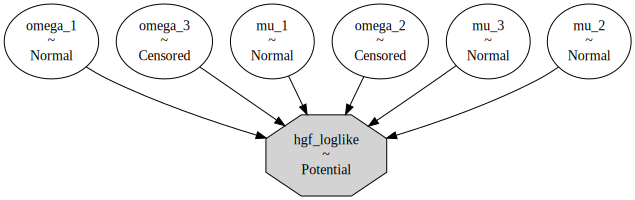

In [39]:
pm.model_to_graphviz(three_level_hgf)

#### Sampling

In [40]:
with three_level_hgf:
    three_level_hgf_idata = pm.sample(chains=4)

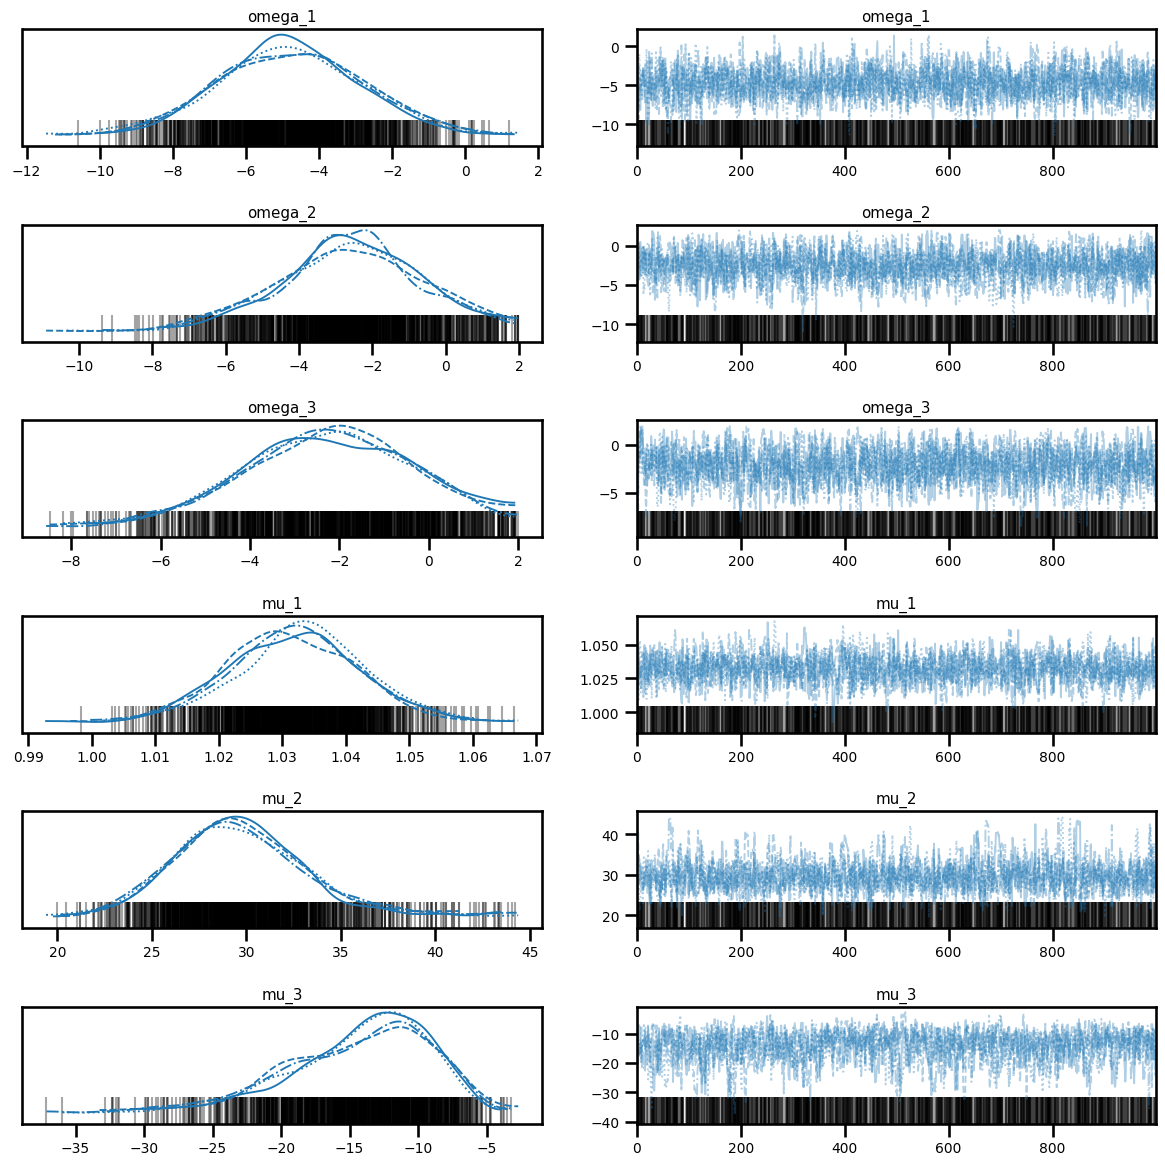

In [41]:
az.plot_trace(three_level_hgf_idata, var_names=["omega_1", "omega_2", "omega_3", "mu_1", "mu_2", "mu_3"]);
plt.tight_layout()

#### Using the learned parameters

In [42]:
omega_1 = az.summary(three_level_hgf_idata)["mean"]["omega_1"]
omega_2 = az.summary(three_level_hgf_idata)["mean"]["omega_2"]
omega_3 = az.summary(three_level_hgf_idata)["mean"]["omega_3"]
mu_1 = az.summary(three_level_hgf_idata)["mean"]["mu_1"]
mu_2 = az.summary(three_level_hgf_idata)["mean"]["mu_2"]
mu_3 = az.summary(three_level_hgf_idata)["mean"]["mu_3"]

In [43]:
hgf_mcmc = HGF(
    n_levels=3,
    model_type="continuous",
    initial_mu={"1": mu_1, "2": mu_2, "3": mu_3},
    initial_pi={"1": 1e4, "2": 1e1, "3": 1e1},
    omega={"1": omega_1, "2": omega_2, "3": omega_3},
    rho={"1": 0.0, "2": 0.0, "3": 0.0},
    kappas={"1": 1.0, "2": 0.0}).input_data(
        input_data=timeserie
    )

Creating a continuous Hierarchical Gaussian Filter with 3 levels.
Add 614 new continuous observations.


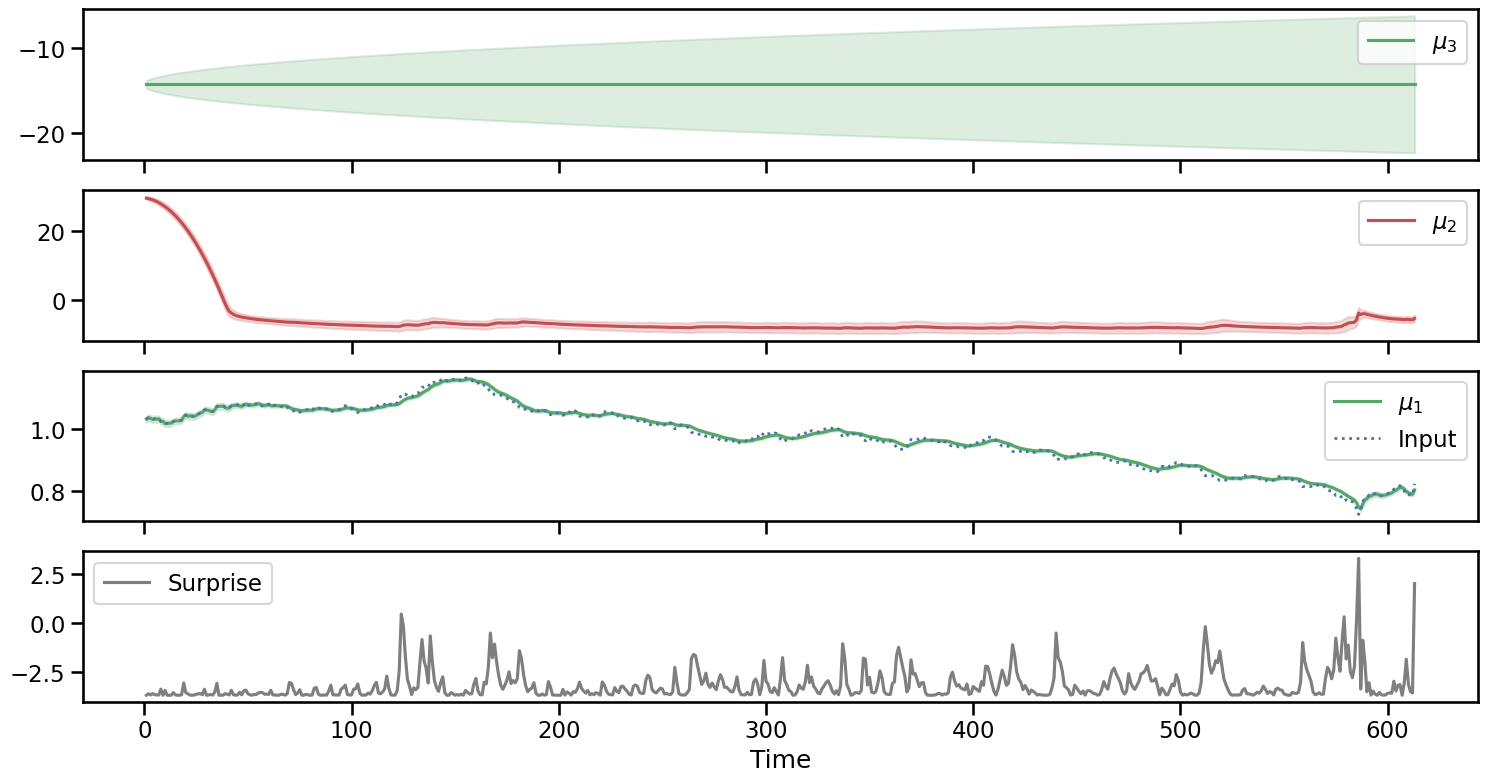

In [44]:
hgf_mcmc.plot_trajectories()

In [45]:
hgf_mcmc.surprise()

DeviceArray(-1941.5087, dtype=float32)

## System configuration

In [46]:
%load_ext watermark
%watermark -n -u -v -iv -w -p ghgf,jax,jaxlib

Last updated: Mon Jan 23 2023

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 8.4.0

ghgf  : 0.0.1.dev0
jax   : 0.3.5
jaxlib: 0.3.22

matplotlib: 3.4.3
seaborn   : 0.12.1
pymc      : 5.0.2
arviz     : 0.13.0
jax       : 0.3.5

Watermark: 2.3.1

